<a href="https://www.kaggle.com/code/aurelegermain/humor-detection-bert-fine-tuning-tf-pytorch?scriptVersionId=172343276" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


This notebook was made using the accelrator "GPU T4 x 2". You need it in order to run the notebook because for the pytorch version I explicitly select the second gpu (to circumvent a gpu memory problem).

# Model version
1. [Tensorflow](#tensorflow)
2. [Pytorch](#pytorch)

# Data loading

In [2]:
df = pd.read_csv('/kaggle/input/200k-short-texts-for-humor-detection/dataset.csv',
                dtype={
                    'text': str, 
                    'humor': int, #Impotant fo binary classification using pytorch dataset
                })

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [4]:
texts = df['text'].to_list()
labels = df['humor'].to_list()

Just to see if we have the same number of humorous and non humorous texts.

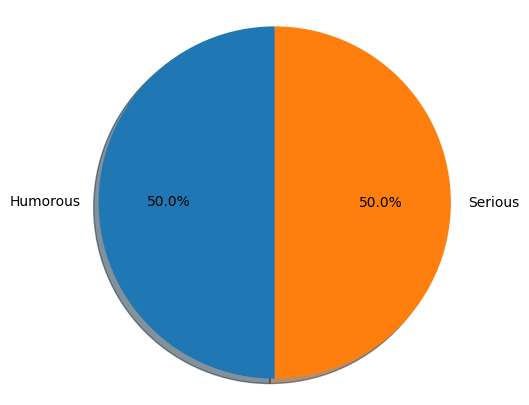

In [5]:
import matplotlib.pyplot as plt   

fig = plt.figure(figsize=(5, 5))
labels_pie = 'Humorous', 'Serious'
sizes = [sum(labels), len(labels) - sum(labels)] 

plt.pie(sizes, labels=labels_pie, autopct='%1.1f%%',
        shadow=True, startangle=90)

plt.axis('equal')  

plt.show()

We are going to split it in three datasets Train/Valid/Test with sizes 80/10/10%. 

In [6]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=.2, random_state=1)

In [7]:
test_texts, val_texts, test_labels, val_labels = train_test_split(test_texts, test_labels, test_size=.5, random_state=1)

We will be using BERT base so we need to tokenize the texts using the BERT base specifications.

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [10]:
#train_encodings = tokenizer(train_texts, padding="max_length")
#val_encodings = tokenizer(val_texts, padding="max_length")
#test_encodings = tokenizer(test_texts, padding="max_length")

# Tensorflow
<a id='tensorflow'></a>

Now we put our tokenized sentences into TensorFlow objects.

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

In [12]:
small_train_dataset = train_dataset.take(1000)
small_eval_dataset = val_dataset.take(1000)
small_test_dataset = test_dataset.take(1000)

it's time to define the model (Bert base) and fine tune it.

As it takes a long time to run and we have a limited GPU and TPU time we will train for 3 epochs (it should gives good results either way).

In [13]:
from transformers import TFBertForSequenceClassification, BertConfig

BATCH_SIZE = 16
BUFFER_SIZE = 1000

config = BertConfig.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
model.fit(small_train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE), epochs=3, validation_data=small_eval_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE))

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
63/63 [==============================] - 76s 356ms/step - loss: 0.2961 - accuracy: 0.8960 - val_loss: 0.1957 - val_accuracy: 0.9310
Epoch 2/3
63/63 [==============================] - 18s 284ms/step - loss: 0.0987 - accuracy: 0.9670 - val_loss: 0.1062 - val_accuracy: 0.9660
Epoch 3/3
63/63 [==============================] - 17s 266ms/step - loss: 0.0141 - accuracy: 0.9980 - val_loss: 0.1398 - val_accuracy: 0.9620


Time to do some predictions.

In [14]:
preds = model.predict(small_test_dataset.batch(BATCH_SIZE))

63/63 [==============================] - 7s 58ms/step


In [15]:
 predicted_class = np.argmax(preds["logits"], axis=1)

The accuracy of the model on the test set:

In [16]:
len_small_test_dataset = len(small_test_dataset)
test_accuracy =  np.sum(predicted_class == test_labels[0:len_small_test_dataset])/ len_small_test_dataset
test_accuracy

0.953

Not bad, maybe with more GPU or TPU time we could decrease the number of errors.

Some random examples of predictions:

In [17]:
nbr_exmp = 5

for i in range(nbr_exmp):
    rndm_i = random.randint(0, len_small_test_dataset)
    print('Text: ', test_texts[rndm_i], '; Label: ', test_labels[rndm_i], '; Prediction: ', bool(predicted_class[rndm_i]))

Text:  I know they took some creative liberties with 'noah' but i really wasn't expecting that prius. ; Label:  1 ; Prediction:  True
Text:  Why are there so few gay comedians? it's hard for them to keep a straight face. ; Label:  1 ; Prediction:  True
Text:  Why were the people in twin towers upset? they ordered pepperoni pizza but all they got was plane ; Label:  1 ; Prediction:  True
Text:  That was samuel jackson's first ever public appearance without saying mother$ucker ; Label:  1 ; Prediction:  False
Text:  I named my penis the truth - because women can't handle it. ; Label:  1 ; Prediction:  True


Some inacurate predictions on the test set:

In [18]:
errors_id = np.where((predicted_class == test_labels[0:len_small_test_dataset]) == False)[0]
nbr_exmp = 5

for i in range(nbr_exmp):
    rndm_i = random.randint(0, len(errors_id))
    print('Text: ', test_texts[errors_id[rndm_i]], '; Label: ', test_labels[errors_id[rndm_i]], '; Prediction: ', bool(predicted_class[errors_id[rndm_i]]))

Text:  What would you say to cancer if you only had five words? ; Label:  0 ; Prediction:  True
Text:  Who has the real power to stop smoking? hint: not smokers ; Label:  0 ; Prediction:  True
Text:  What would you say to cancer if you only had five words? ; Label:  0 ; Prediction:  True
Text:  Where has the time gone? sending your child off to college ; Label:  0 ; Prediction:  True
Text:  They dreamed of putting a woman in the white house. now they wait anxiously. ; Label:  0 ; Prediction:  True


# Pytorch
<a id='pytorch'></a>

Now I will do the same thing using Pytorch.

First we add the labels to the train, valid, and test encodings.

In [19]:
train_encodings['labels'] = train_labels
val_encodings['labels'] = val_labels
test_encodings['labels'] = test_labels

Now we build the Pytorch Dataset using DatasetDict and Dataset.from_dict().

In [20]:
from datasets.dataset_dict import DatasetDict
from datasets import Dataset

py_dataset = DatasetDict({'train': Dataset.from_dict(train_encodings), 'val': Dataset.from_dict(val_encodings), 'test': Dataset.from_dict(test_encodings)})
py_dataset.set_format("torch")

In [21]:
py_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 160000
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
})

We are going to select only 1000 entries of each set to limit the time taken to train the model. If you want you can select the entires sets by deleting ".select()".

In [22]:
py_small_train_dataset = py_dataset["train"].shuffle(seed=42).select(range(1000))
py_small_eval_dataset = py_dataset["val"].shuffle(seed=42).select(range(1000))
py_small_test_dataset = py_dataset["test"].shuffle(seed=42).select(range(1000))

The dataloader for each dataset.

In [23]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(py_small_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
eval_dataloader = DataLoader(py_small_eval_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(py_small_test_dataset, batch_size=BATCH_SIZE)

We download the pre-trained bert model. "num_labels" is set to 2 for a binary classification (and not 1). The labels must be as type int (or long for pytorch) for this to work.

In [24]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [26]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [27]:
import torch

device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

We will use this function to compute the accuracy for the validation and test sets.

In [28]:
def batch_accuracy(logits, labels):
    predictions = np.argmax(logits, axis=1)
    return np.sum(predictions == labels)/len(predictions)

In [29]:
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    model.train()
    for step, batch in enumerate(train_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        print(f"Step: {step + 1}/{len(train_dataloader)} Train loss: {loss.item()}", end='\r')
        
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
    print("\r")
    
    val_accuracy = 0
    for step, batch in enumerate(eval_dataloader):
        model.eval()
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
    
        logits = outputs.logits
        logits = logits.cpu().numpy()
        
        labels = batch['labels']
        labels = labels.to('cpu').numpy()
        
        b_accuracy = batch_accuracy(logits, labels)
        val_accuracy += b_accuracy
    val_accuracy /= len(eval_dataloader)
    print(f"Val set accuracy: {val_accuracy:.5f}")

Epoch 1/3

Val set accuracy: 0.95040
Epoch 2/3

Val set accuracy: 0.95635
Epoch 3/3

Val set accuracy: 0.95437


In [30]:
model.eval()

test_accuracy = 0

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    
    logits = outputs.logits
    logits = logits.cpu().numpy()
        
    labels = batch['labels']
    labels = labels.to('cpu').numpy()
    
    b_accuracy = batch_accuracy(logits, labels)
    test_accuracy += b_accuracy

test_accuracy /= len(test_dataloader)
print(f"Test set accuracy: {test_accuracy:.5f}")

Test set accuracy: 0.95139


In [31]:
#!pip install GPUtil

#from GPUtil import showUtilization as gpu_usage
#gpu_usage()  